# Initalize libraries

## Import libraries

In [18]:
# general
import sys, os
import time
from os.path import join
from os import path
from importlib import reload
from getpass import getuser
from glob import glob
from tqdm.auto import tqdm
from multiprocessing import Pool

# Data
import xarray as xr
import h5py
import numpy as np
import imageio
from nexusformat.nexus import *
from PIL import Image

# Plotting
import matplotlib.pyplot as plt

# skimage
import skimage.morphology
from skimage.draw import ellipse

# scipy
from scipy.ndimage.filters import gaussian_filter
from scipy import stats

# pyFAI
import pyFAI
from pyFAI.azimuthalIntegrator import AzimuthalIntegrator
from pyFAI.detectors import Detector

# Self-written libraries
sys.path.append(join(os.getcwd(), "library"))
import fthcore as fth
import helper_functions as helper
import mask_lib
import interactive
from interactive import cimshow
import reconstruct_rb as rec
import reconstruct as reco

# Facility specific loading functions
import MAXI_loading as loading

plt.rcParams["figure.constrained_layout.use"] = True  # replaces plt.tight_layout

/tmp/ipykernel_45936/1835607318.py:28: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


In [19]:
# Is there a GPU?
try:
    # Cupy
    import cupy as cp
    import cupyx as cpx

    GPU = True

    print("GPU available")

    # Self-written library
    import CCI_core_cupy as cci
    import Phase_Retrieval as PhR
except:
    GPU = False
    import CCI_core as cci

    print("GPU unavailable")

GPU available


In [20]:
# interactive plotting
import ipywidgets

%matplotlib widget

# Auto formatting of cells
#%load_ext jupyter_black


## Experiment specific Functions

In [21]:
PROPOSAL = 11018955
USER = getuser()

BASEFOLDER = "/data/export/cklose/2409_MAXIV"#"/asap3/petra3/gpfs/p04/2024/data/%s/" % PROPOSAL
sample_name = "2408_"
spefile_name = "scan"

# Load mnemonics for easy data handling
mnemonics = loading.mnemonics

### Loading data

In [22]:
def generate_filename(scan_nr,file_format=".h5"):
    """
    Generates filename of the given scan id
    
    Parameter
    =========
    file_format : str
        file format (ending, e.g. ".nxs")
    scan_nr : int or str
        number identifier (id) of the given scan
        
    Output
    ======
    filename : str
        full generated filename
    ======
    author: ck 2024
    """

    # Convert scan number to string
    if type(scan_nr) == int:
        scan_nr = "%d" % scan_nr
    elif isinstance(scan_nr, np.generic):
        scan_nr = "%d" % scan_nr
        
    # Combine all inputs
    filename = join(BASEFOLDER,"data","raw",sample_name+scan_nr+file_format)
    
    return filename

def load_data(scan_id, keypath = mnemonics["pre_scan_snapshot"], keys = None):
    """
    Load data of all specified keys from keypath
    
    Parameter
    =========
    scan_id : int
        experimental identifier of scan
    keypath : str
        path of nexus file tree to relevant data field
    keys : str or list of strings
        keys to load from keypath
        
    Output
    ======
    data : dict
        data dictionary of keys
    ======
    author: ck 2024
    """
        
    #Generate filename from scan_id
    fname = generate_filename(scan_id)
    
    # load data with basic loading function
    data = loading.load_data(fname, keypath, keys = keys)
    
    return data


def load_key(scan_id, key):
    """
    Load any kind of data specified by key (path)
    
    Parameter
    =========
    scan_id : int
        experimental identifier of scan
    key : str
        key path of nexus file tree to relevant data field
   
    Output
    ======
    data : dict
        data dictionaray on single key
    ======
    author: ck 2024
    """
    #Generate filename from scan_id
    fname = generate_filename(scan_id)
    
    # load data with basic loading function
    data = loading.load_key(fname, key)
    
    return data

### Loading images

In [23]:
def get_filepath(tiffname, camera_type = "cmos"):
    """Return raw data path from save file path."""
    head, tifffile = path.split(tiffname)
    head, scandir = path.split(head)
    return path.join(BASEFOLDER,"data","raw", camera_type, scandir, tifffile)

def load_tiff(tifffile):
    """load single tiff image into np array"""
    return np.array(Image.open(tifffile))

def load_tiff_list(filelist, processes=None):
    """Multiprocessing loading of image files"""
    with Pool(processes=processes) as pool:
        frames = pool.map(load_tiff, filelist)
    return np.stack(frames)

def load_cmos(scanid):
    # Load averaged image if it does exist
    fname = join(BASEFOLDER,"data","raw","cmos", "scan_%04d"%scanid, "scan_%04d_avg.h5"%scanid)

    if os.path.exists(fname):        
        print("Loading: %s"%fname)
        with h5py.File(fname, "r") as f:
            # Get entry
            image = f["image"][()].squeeze()
    
        return image

    # Loads all single frames
    else:
        print("Loading single frames")
        fname = generate_filename(scanid,".h5")
        cmos_filelist = load_key(scanid,mnemonics["cmos"])
        cmos_filelist = [get_filepath(b.decode(),camera_type = "cmos") for b in cmos_filelist]
        
    return load_tiff_list(cmos_filelist)

def load_images(im_id, camera_type = "ccd"):
    """
    Loads all images of a given image id
    
    Parameter
    =========
    im_id : int
        experimental identifier of image scan
    camera_type : str
        "ccd" or "cmos", select corresponding kezy from mnemonics dict
   
    Output
    ======
    images : array
        stack of all images the correspond to the id
    ======
    author: ck 2024
    """

    if camera_type == "ccd":
        # Find spe files
        spe_file_list = [get_filepath(b.decode(),camera_type = "ccd") for b in cmos_filelist]
        
        # Loop over image spe files
        images = []
        for spe_file in spe_file_list:
            images.append(np.squeeze(np.array(imageio.mimread(spe_file, memtest="5000MB"))))

        # Stack to 3d array
        images = np.stack(images)
    elif camera_type == "cmos":
        images = load_cmos(im_id)

    return images

### Loading image procedure

In [24]:
# Full image loading procedure
def load_processing(im_id, crop=None,camera_type = "cmos"):
    """
    Loads images, averaging of two individual images (scans in tango consist of two images),
    padding to square shape, Additional cropping (optional)
    """

    # Load data
    images = load_images(im_id,camera_type=camera_type)

    # Zeropad to get square shape
    #images = helper.padding(images)

    # Calculate mean
    if images.ndim > 2:
        image = np.mean(images, axis=0)
    else:
        image = images.copy()

    # Optional cropping
    if crop is not None:
        images = images[:, :crop, :crop]
        image = image[:crop, :crop]

    return image, images

### Loading, saving fth & cdi data

In [25]:
# Saving of log files for fth and cdi recos
def save_fth_h5():
    # Save h5
    data = {}
    data["im_id"] = im_id
    data["topo_id"] = topo_id
    data["topo_centered"] = topo_c
    data["im_centered"] = im_c
    data["holo"] = holo
    data["recon"] = recon
    data["factor"] = factor
    data["offset"] = offset
    data["center"] = center
    data["roi"] = roi
    data["prop_dist"] = prop_dist
    data["phase"] = phase
    data["mask_bs"] = mask_pixel_smooth
    data["bs_smoothing"] = bs_smoothing
    data["experimental_setup"] = experimental_setup

    filename = join(
        folder_general, "Logs", "Data_ImId_%04d_RefId_%s_%s" % (im_id, topo_id, USER)
    )
    print("Now Saving: %s" % filename)
    cci.create_hdf5(data, filename)


def save_cdi_h5():
    # Save h5
    data = {}
    data["im_id"] = im_id
    data["topo_id"] = topo_id
    data["pos"] = pos
    data["neg"] = neg
    data["factor"] = factor
    data["offset"] = offset
    data["center"] = center
    data["roi"] = roi
    data["prop_dist"] = prop_dist_cdi
    data["phase"] = phase_cdi
    data["mask_bs"] = mask_bs_cdi
    data["supportmask"] = supportmask
    data["mask_pixel"] = mask_pixel
    data["p_pc"] = p_pc
    data["n_pc"] = n_pc
    data["experimental_setup"] = experimental_setup

    filename = join(
        folder_general,
        "Logs",
        "Data_ImId_%04d_RefId_%s_cdi_%s" % (im_id, topo_id, USER),
    )
    print("Now Saving: %s" % filename)
    cci.create_hdf5(data, filename)
    return


def save_topo_holo(topo_c, pos_id, neg_id):
    """
    Save only topo holos which can be later used for single helicity reconstructions
    """
    data = {}
    data["pos_id"] = pos_id
    data["neg_id"] = neg_id
    data["topo"] = topo_c

    filename = join(
        folder_general,
        "Topos",
        "Topo_ImId_%04d_RefId_%04d_cdi_%s" % (pos_id, neg_id, USER),
    )
    print("Now Saving: %s" % filename)
    cci.create_hdf5(data, filename)
    return

def load_fth(im_id, topo_id):
    """
    Load fth dataset
    """
    fname = join(
        folder_target,
        "Logs",
        "Data_ImId_%s_RefId_%s_%s.hdf5"
        % (
            im_id,
            topo_id,
            USER,
        ),
    )

    with h5py.File(fname, "r") as f:
        data = {}
        for key in f.keys():
            if key != "experimental_setup":
                data[key] = f[key][()]

    return data

def load_topo_holo(pos_id, neg_id):
    """
    Load topo holos for single helicity reconstructions
    """
    fname = join(
        folder_general,
        "Topos",
        "Topo_ImId_%04d_RefId_%04d_cdi_%s.hdf5" % (pos_id, neg_id, USER),
    )

    with h5py.File(fname, "r") as f:
        im_out = f["topo"][()]
    return im_out


def load_cdi(im_id, topo_id):
    """
    Load cdi dataset
    """
    fname = join(
        folder_general,
        "Logs",
        "Data_ImId_%04d_RefId_%s_cdi_%s.hdf5" % (im_id, topo_id, USER),
    )

    with h5py.File(fname, "r") as f:
        data = {}
        for key in f.keys():
            if key != "experimental_setup":
                data[key] = f[key][()]
    return data_cdi

### Other

In [26]:
def differential_operator(shape,center, experimental_setup, angle = 0):
    '''
    Calculates Fourier-space differential operator for heraldo reconstruction
    
    Parameter
    ---------
    shape: int tuple
        shape of output array
    center: tuple
        array center coordinates (y,x) 
    experimental_setup: dict
        must contain detector pixel_size ["px_size"], distance ["ccd_dist"],
        wavelength ["lambda"]
    angle: float
        rotation angle of heraldo slit
        
    Returns:
    --------
    return: complex array
        differential operator in Fourier space
    '''
    
    # Convert deg to rad
    angle = np.deg2rad(angle)
    
    # Create x,y grid to convert pixel in q-space
    x, y = np.meshgrid(np.arange(shape[0]),np.arange(shape[0]))
    
    # Center meshgrid
    y, x = y - center[0],  x - center[1]
    
    # Multiplay with pixel size
    y, x = y*experimental_setup["px_size"], x*experimental_setup["px_size"]
    
    # Convert to q-space
    qy = 4*np.pi/experimental_setup["lambda"] * np.sin(0.5*np.arctan(y/experimental_setup["ccd_dist"]))
    qx = 4*np.pi/experimental_setup["lambda"] * np.sin(0.5*np.arctan(x/experimental_setup["ccd_dist"]))
    
    # Normalize q space to [-1,1]
    qy, qx = qy/np.max(np.abs(qy)), qx/np.max(np.abs(qx))
    
    return 2j*np.pi*qx*np.cos(angle) + 2j*np.pi*qy*np.sin(angle)

In [27]:
def reconstruct_heraldo(holo, experimental_setup, center = None, prop_dist = 0, phase = 0,angle = 0):
    '''
    Reconstruction of holograms in heraldo reference scheme
    
    Parameter:
    ----------
    holo: array
        Centered input hologram
    experimental_setup: dict
        must contain detector pixel_size ["px_size"], distance ["ccd_dist"],
        wavelength ["lambda"]
    center: tuple or None
        array center coordinates (y,x) 
    prop_dist: float
        propagation distance
    phase: float
        global phase shift of complex array
    angle: float
        rotation angle of heraldo slit
        
    returns:
    image: array
        reconstructed image
    heraldo_operator: complex array
        differential operator in Fourier space
    '''
    
    if center is None:
        center = np.array(holo.shape)/2
    
    heraldo_operator = differential_operator(holo.shape,center, 
                    experimental_setup, angle = angle)
    holo = holo * heraldo_operator
    holo = fth.propagate(holo, prop_dist*1e-6, experimental_setup = experimental_setup)*np.exp(1j*phase)
    image = fth.reconstruct(holo)
    
    return image, heraldo_operator

In [28]:
# Worker which performs complete fth reconstruction process
def worker(image, topo):
    # Centering
    shift_c = np.array(topo.shape) / 2 - center
    topo_c = cci.shift_image(topo, shift_c)
    im_c = cci.shift_image(image, shift_c)
    
    ## Image registration
    shift = cci.image_registration(
        im_c[roi_im_reg],
        topo_c[roi_im_reg],
        method="dipy",
    )

    print("Relative shift is: %s"%shift)

    
    # Correct relative drift
    topo_c = cci.shift_image(topo_c, shift) 
    
    # Optional ewalds sphere projection
    if project_ewalds_sphere is True:
        %%time
        proj_im = PhR.inv_gnomonic2(im_c,alpha=experimental_setup["angle"], center=None, experimental_setup = experimental_setup, method='cubic' , mask=None)
        proj_topo = PhR.inv_gnomonic2(topo_c,alpha=experimental_setup["angle"], center=None, experimental_setup = experimental_setup, method='cubic' , mask=None)

        im_c = proj_im.copy()
        topo_c = proj_topo.copy()

    # Create masks
    # Load polygon mask and shift to manually determined position
    mask = mask_lib.load_poly_masks(
    experimental_setup["binning"] * np.array(image.shape),
    load_poly_coordinates(),
    polygon_names,)
    mask = np.round(cci.shift_image(mask,mask_shift))
    
    # Increase/Decrease mask size
    footprint = skimage.morphology.disk(np.abs(mask_scale))
    if mask_scale > 0:
        mask = skimage.morphology.dilation(mask, footprint) # increase size
    elif mask_scale < 0: 
        mask = skimage.morphology.erosion(mask, footprint) # decrease size

    # Create image specific beamstop mask
    mask_im = mask.copy()
    mask_im = mask_im + (im_c > experimental_setup["oversaturation"])
    mask_im[mask_im > 1] = 1

    # Create topo specific beamstop mask
    mask_topo = mask.copy()
    mask_topo = mask_topo + (topo_c > experimental_setup["oversaturation"])

    # Combine both
    mask_pixel = mask_im + mask_topo
    mask_pixel[mask_pixel > 1] = 1
    
    # Create smooth mask
    footprint = skimage.morphology.disk(4)
    mask_pixel_smooth = skimage.morphology.dilation(mask_pixel, footprint)
    mask_pixel_smooth = gaussian_filter(mask_pixel_smooth, 2)

    # Get scaling factor and offset
    factor, offset = cci.dyn_factor(
        im_c * (1 - mask_pixel),
        topo_c * (1 - mask_pixel),
        method="correlation",
        verbose=False,
        plot=False,
    )

    # Calculate differences (magnetic) and sums (topographc) contrast holograms.
    # _c: centered, without beamstop, _b: centered, with beamstop
    diff_c = im_c / factor - topo_c - offset
    sum_c = im_c / factor + topo_c - offset

    if heraldo is True:
        #holo = sum_c * heraldo_operator * mask_bs*(1 - mask_pixel_smooth)
        holo = diff_c * heraldo_operator * (1 - mask_pixel_smooth)
    elif heraldo is False:
        #holo = sum_c * mask_bs*(1 - mask_pixel_smooth)
        holo = diff_c * (1 - mask_pixel_smooth)

    # Reconstruct
    recon = cci.reconstruct(
        fth.propagate(holo, prop_dist * 1e-6, experimental_setup=experimental_setup)
        * np.exp(1j * phase)
    )

    # worker dictionary
    worker_dict = {}
    worker_dict["center"] = center
    worker_dict["topo_c"] = topo_c
    worker_dict["im_c"] = im_c
    worker_dict["recon"] = recon
    worker_dict["factor"] = factor
    worker_dict["offset"] = offset
    worker_dict["shift"] = shift
    worker_dict["diff_c"] = diff_c
    worker_dict["sum_c"] = sum_c
    worker_dict["mask_bs"] = mask_pixel_smooth
    worker_dict["mask_pixel"] = mask_pixel
    
    return worker_dict

In [29]:
# Setup phase and propagation for cdi once
phase_cdi = 0
prop_dist_cdi = 0
dx = 0
dy = 0


def phase_retrieval(
    pos, neg, mask_pixel, supportmask, vmin = 0, Startimage=None, Startgamma=None
):
    # Prepare Input holograms
    pos2 = pos.copy()
    neg2 = neg.copy()

    mi, _ = np.percentile(pos2[pos2 != 0], [vmin, 99.9])
    pos2 = pos2 - mi
    mi, _ = np.percentile(neg2[neg2 != 0], [vmin, 99.9])
    neg2 = neg2 - mi

    pos2[pos2 < 0] = 0
    neg2[neg2 < 0] = 0
    pos2 = pos2.astype(complex)
    neg2 = neg2.astype(complex)

    bsmask_p = mask_pixel.copy()
    bsmask_p[pos2 <= 0] = 1
    bsmask_n = mask_pixel.copy()
    bsmask_n[neg2 <= 0] = 1

    # Setup start image and startgamma
    if Startimage is None:
        Startimage = np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(supportmask)))
    else:
        Startimage = Startimage.copy()
    if Startgamma is None:
        Startgamma = np.ones(pos.shape) * 1e-6 * 2
        Startgamma[pos.shape[0] // 2, pos.shape[1] // 2] = 0.7
    else:
        Startgamma = Startgamma.copy()

    # Settings for phase retrieval reconstructions
    partial_coherence = True

    # Setup
    retrieved_p = np.zeros(pos2.shape, np.cdouble)
    retrieved_n = np.zeros(pos2.shape, np.cdouble)

    # Algorithms and Inital guess
    plt.rcParams["figure.dpi"] = 100
    print("CDI - larger mask")

    algorithm_list = ["mine", "mine", "mine"]
    Nit_list = [700, 50, 50]  # iterations for algorithm_list

    x = (np.sqrt(np.maximum(pos2, np.zeros(pos2.shape)))[mask_pixel == 0]).flatten()
    y = ((np.abs(Startimage))[mask_pixel == 0]).flatten()
    res = stats.linregress(x, y)
    Startimage -= res.intercept
    Startimage /= res.slope

    average_img = 30
    real_object = False  # always set to False

    if partial_coherence:
        RL_freq = 20
        RL_it = 50

        algorithm_list_pc = ["mine", "ER", "ER"]
        Nit_list_pc = [700, 50, 50]

    # Execute Phase retrieval
    start_time = time.time()
    for i in range(len(Nit_list) // 3):
        print("############ -   CDI")

        # Positive helicity - beta_mode="arctan"
        retrieved_p, Error_diff_p, Error_supp = PhR.PhaseRtrv_GPU(
            diffract=np.sqrt(np.maximum(pos2, np.zeros(pos2.shape))),
            mask=supportmask,
            mode=algorithm_list[3 * i],
            beta_zero=0.5,
            Nit=Nit_list[3 * i],
            beta_mode="arctan",
            plot_every=349,
            Phase=Startimage,
            seed=False,
            real_object=real_object,
            bsmask=bsmask_p,
            average_img=average_img,
            Fourier_last=True,
        )

        # Positive helicity - beta_mode="const"
        retrieved_p, Error_diff_p2, Error_supp = PhR.PhaseRtrv_GPU(
            diffract=np.sqrt(np.maximum(pos2, np.zeros(pos2.shape))),
            mask=supportmask,
            mode=algorithm_list[3 * i + 1],
            beta_zero=0.5,
            Nit=Nit_list[3 * i + 1],
            beta_mode="const",
            plot_every=24,
            Phase=retrieved_p,
            seed=False,
            real_object=real_object,
            bsmask=bsmask_p,
            average_img=average_img,
            Fourier_last=True,
        )

        # Negative helicity - beta_mode="arctan"
        retrieved_n, Error_diff_n2, Error_supp = PhR.PhaseRtrv_GPU(
            diffract=np.sqrt(np.maximum(neg2, np.zeros(neg2.shape))),
            mask=supportmask,
            mode=algorithm_list[3 * i + 2],
            beta_zero=0.5,
            Nit=Nit_list[3 * i + 2],
            beta_mode="const",
            plot_every=24,
            Phase=retrieved_p * np.sqrt(np.sum(neg2) / np.sum(pos2)),
            seed=False,
            real_object=real_object,
            bsmask=bsmask_n,
            average_img=average_img,
            Fourier_last=True,
        )

        print("--- %s seconds ---" % np.round((time.time() - start_time), 2))

        Startimage = retrieved_p.copy()

        # Partial coherence phase retrieval
        if partial_coherence:
            # CDI_PC
            print("############   -   CDI_pc")
            pos3 = (np.abs(retrieved_p) ** 2) * bsmask_p + np.maximum(
                pos2, np.zeros(pos2.shape)
            ) * (1 - bsmask_p)
            neg3 = (np.abs(retrieved_n) ** 2) * bsmask_n + np.maximum(
                neg2, np.zeros(neg2.shape)
            ) * (1 - bsmask_n)

            # retrieve pos image
            (
                retrieved_p_pc,
                Error_diff_p_pc,
                Error_supp,
                gamma_p,
            ) = PhR.PhaseRtrv_with_RL(
                diffract=np.sqrt(pos3),
                mask=supportmask,
                mode=algorithm_list_pc[3 * i],
                beta_zero=0.5,
                Nit=Nit_list_pc[3 * i],
                beta_mode="arctan",
                gamma=Startgamma,
                RL_freq=RL_freq,
                RL_it=RL_it,
                plot_every=349,
                Phase=Startimage,
                seed=False,
                real_object=False,
                bsmask=np.zeros(bsmask_p.shape),
                average_img=average_img,
                Fourier_last=True,
            )

            (
                retrieved_p_pc,
                Error_diff_p_pc2,
                Error_supp,
                gamma_p,
            ) = PhR.PhaseRtrv_with_RL(
                diffract=np.sqrt(pos3),
                mask=supportmask,
                mode=algorithm_list[3 * i + 1],
                beta_zero=0.5,
                Nit=Nit_list_pc[3 * i + 1],
                beta_mode="const",
                gamma=gamma_p,
                RL_freq=RL_freq,
                RL_it=RL_it,
                plot_every=24,
                Phase=retrieved_p_pc,
                real_object=False,
                bsmask=np.zeros(bsmask_p.shape),
                average_img=average_img,
                Fourier_last=True,
            )
            (
                retrieved_n_pc,
                Error_diff_n_pc2,
                Error_supp,
                gamma_n,
            ) = PhR.PhaseRtrv_with_RL(
                diffract=np.sqrt(neg3),
                mask=supportmask,
                mode=algorithm_list[3 * i + 2],
                beta_zero=0.5,
                Nit=Nit_list_pc[3 * i + 2],
                beta_mode="const",
                gamma=gamma_p,
                RL_freq=RL_freq,
                RL_it=RL_it,
                plot_every=24,
                Phase=retrieved_p_pc * np.sqrt(np.sum(neg2) / np.sum(pos2)),
                real_object=False,
                bsmask=np.zeros(bsmask_n.shape),
                average_img=average_img,
                Fourier_last=True,
            )

            print("--- %s seconds ---" % np.round((time.time() - start_time), 2))

            Startimage = retrieved_p_pc.copy()
            Startgamma = gamma_p.copy()

    print("Phase Retrieval Done!")

    return (
        retrieved_p,
        retrieved_n,
        retrieved_p_pc,
        retrieved_n_pc,
        bsmask_p,
        bsmask_n,
        gamma_p,
        gamma_n,
    )

# Experimental Details

In [89]:
# Dict with most basic experimental parameter
experimental_setup = {
    "ccd_dist": 0.195,  # ccd to sample distance
    "px_size": 13.5e-6,  # pixel_size of camera
    "binning": 1,  # Camera binning
    "oversaturation" : 60e3, # Pixel saturation threshold
    "angle": 0
}

# Setup for azimuthal integrator
detector = Detector(
    experimental_setup["binning"] * experimental_setup["px_size"],
    experimental_setup["binning"] * experimental_setup["px_size"],
)
experimental_setup["z_angle_offset"] = 67

# General saving folder and log folder
folder_general = helper.create_folder(join(BASEFOLDER, "processed"))
helper.create_folder(join(folder_general, "Logs"))
helper.create_folder(join(folder_general, "Topos"))
print("Output Folder: %s" % folder_general)

Output Folder: /data/export/cklose/2409_MAXIV/processed


# Load images

Start by loading the images: image of interest (im), reference of charge scattering (topo), any kind of dark image (dark)

We estalished the following convention: Difference Hologram which contains only the magnetic scattering will be calculated according to:

$Diff = \frac{Image}{factor} - Topo$,

where the factor is used for intensity scaling. In Case that you recorded scans of the same magnetic state with both helicities, use the image with negative helicity as topo and the one with positive helicity as image

In [90]:
# Define scan ids for each image
im_id = 333 # single helicity mode: image with magnetic contrast, double helicity: pos
dark_id = 331
topo_id = (
    332  # single helicity mode: image without magnetic contrast, double helicity: neg
)

# Are you using a HERALDO dataset?
heraldo = False

# Are you going to use ewalds sphere projection?
project_ewalds_sphere = True

# Load energy and add to experimental setup
experimental_setup["energy"] = load_key(im_id,mnemonics["energy"])
experimental_setup["lambda"] = helper.photon_energy_wavelength(
    experimental_setup["energy"], input_unit="eV"
)

print("Image Id: %s" % im_id)
print("Topo Id: %s" % topo_id)
print("Dark Id: %s" % dark_id)

Image Id: 333
Topo Id: 332
Dark Id: 331




## Load image of interest

Loading: /data/export/cklose/2409_MAXIV/data/raw/cmos/scan_0333/scan_0333_avg.h5


interactive(children=(FloatRangeSlider(value=(70.56101, 2295.9920233333983), description='contrast', layout=La…

Text(0.5, 1.0, 'Image')

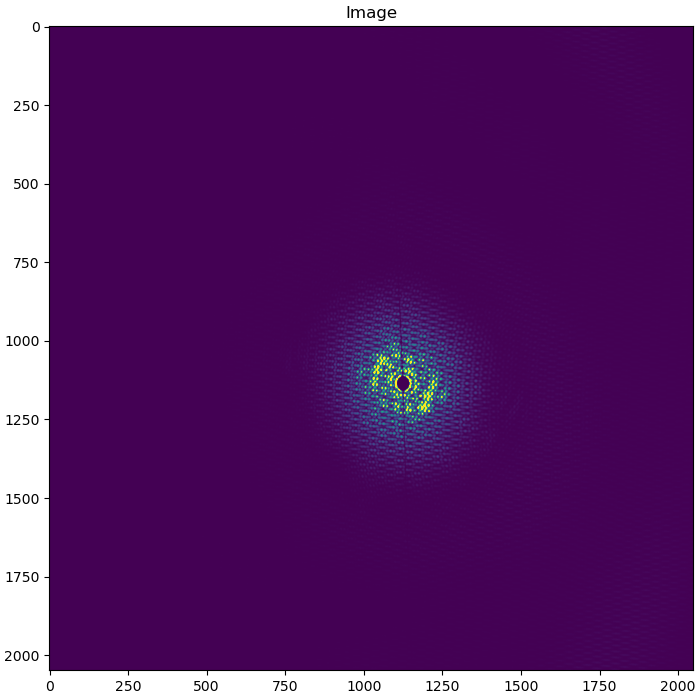

In [70]:
# Load image
image, _ = load_processing(im_id, crop=None)

# Plot
fig, ax = cimshow(image)
ax.set_title("Image")

## Load topo data set and average

Loading: /data/export/cklose/2409_MAXIV/data/raw/cmos/scan_0332/scan_0332_avg.h5


interactive(children=(FloatRangeSlider(value=(70.51666666666667, 2429.3979800000043), description='contrast', …

Text(0.5, 1.0, 'Topo')

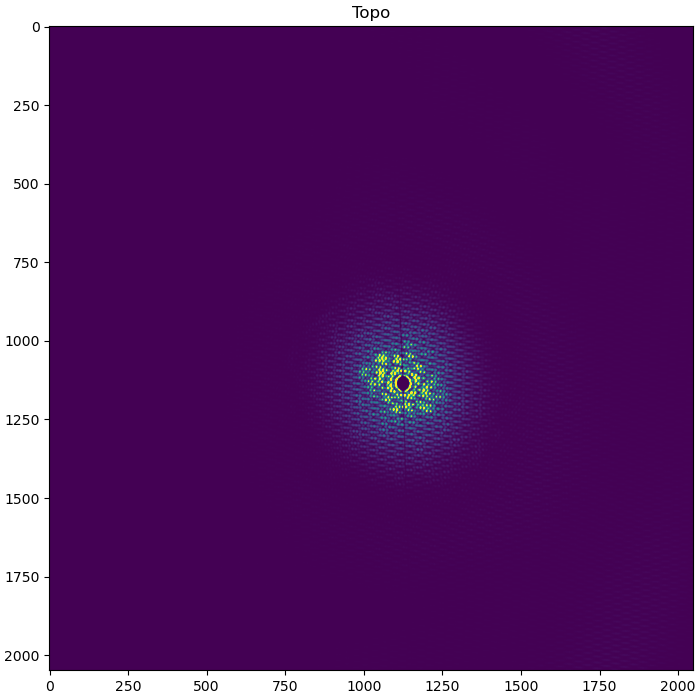

In [71]:
# Load topo
topo, _ = load_processing(topo_id , crop=None)

# Plot
fig, ax = cimshow(topo)
ax.set_title("Topo")

## Load dark image

Loading: /data/export/cklose/2409_MAXIV/data/raw/cmos/scan_0331/scan_0331_avg.h5


interactive(children=(FloatRangeSlider(value=(68.8, 74.3), description='contrast', layout=Layout(width='500px'…

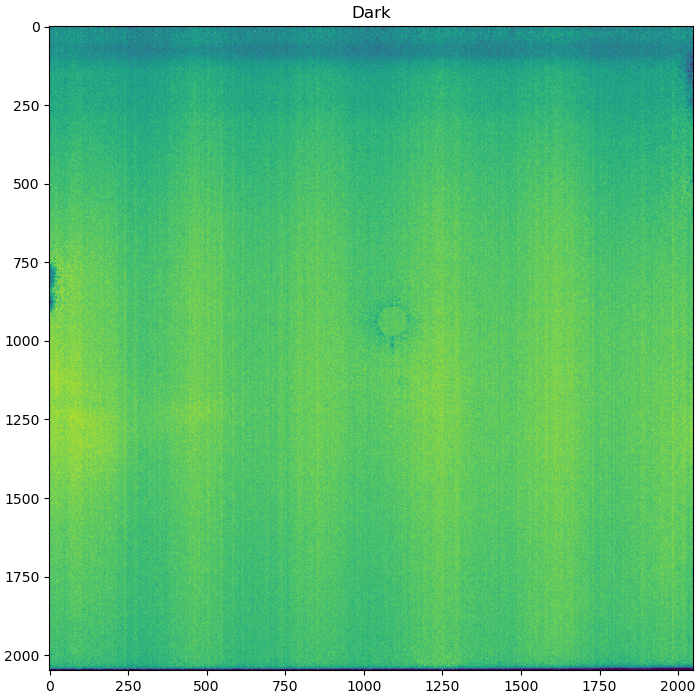

In [72]:
# Load image
if dark_id is not None:
    dark, _ = load_processing(dark_id, crop=None)
    
    image = image - dark
    topo = topo - dark
    
    # Plot
    fig, ax = cimshow(dark)
    ax.set_title("Dark")

interactive(children=(FloatRangeSlider(value=(1.6385890832927168, 3.3554293639072066), description='contrast',…

Text(0.5, 1.0, 'Image')

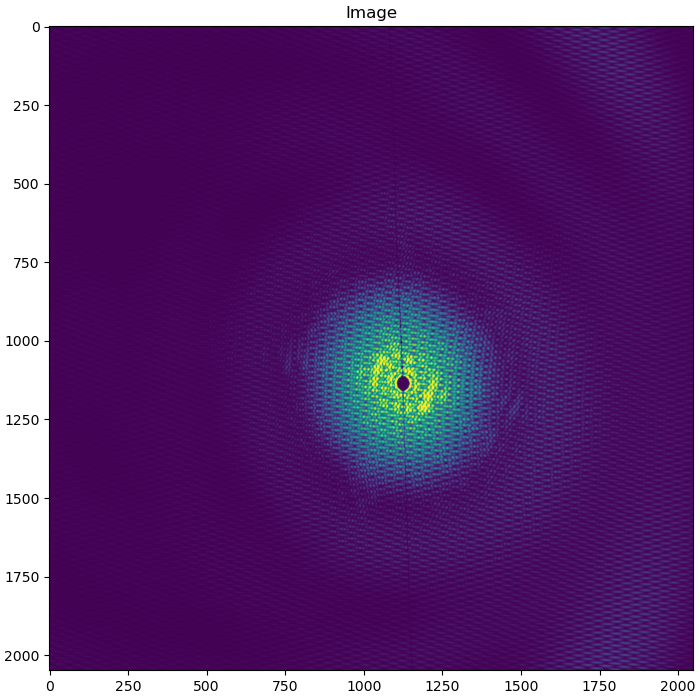

In [73]:
# Plot
fig, ax = cimshow(np.log10(image-np.min(image)+1))
ax.set_title("Image")

# Center holograms

* Find center of the hologram to get a well-defined q-space. 
* Create smooth mask for beamstop or overexposed areas in direct beam

## Basic widget to find center

Try to **align** the circles to the **center of the scattering pattern**. Care! Position of beamstop might be misleading and not represent the actual center of the hologram. Circles are just a guide to eye and will not be used otherwise.

interactive(children=(FloatRangeSlider(value=(-0.3499999999999943, 2223.024353333538), description='contrast',…

interactive(children=(IntText(value=1135, description='c0 (vert)', step=0), IntText(value=1126, description='c…

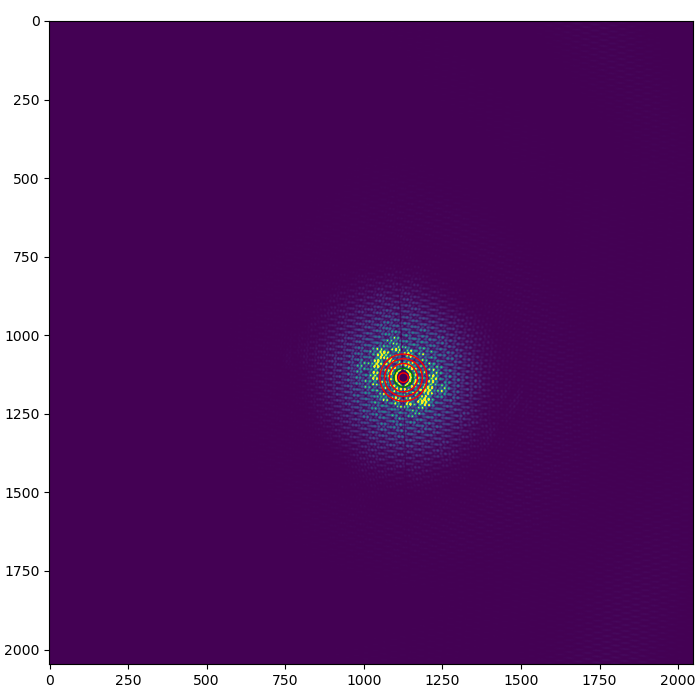

In [74]:
# Find center position via widget
c0, c1 = [1135, 1126]  # initial values
ic = interactive.InteractiveCenter(image, c0=c0, c1=c1)

In [75]:
# Get center positions
center = [ic.c0, ic.c1]
print(f"Center:", center)

Center: [1135, 1126]


## Azimuthal integrator widget for finetuning
More of an "expert widget" which works very well for alignment if you have an Airy Pattern as a scattering image. PyFai transforms images from carthesian detector coordinate system into polar coordinate system with angle `phi` and radial distance `q` as axis (azimuthal transformation). The center of the coordinate system will be defined in the azimuthal integrator class and must not necessarily represents the center coordinates of your image array. If the center is set correctly, all rings of the Airy pattern will be transformed into a straight line in the I(q,chi)-plot as rings appear at a given q for all angles chi.

In [76]:
# Setup azimuthal integrator for virtual geometry
ai = AzimuthalIntegrator(
    dist=experimental_setup["ccd_dist"],
    detector=detector,
    wavelength=experimental_setup["lambda"],
    poni1=center[0]
    * experimental_setup["px_size"]
    * experimental_setup["binning"],  # y (vertical)
    poni2=center[1]
    * experimental_setup["px_size"]
    * experimental_setup["binning"],  # x (horizontal)
)

Text(0.5, 1.0, 'Azimuthal integration')

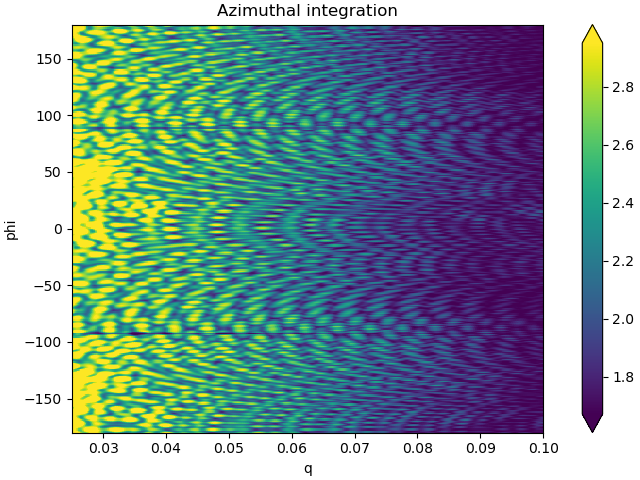

In [77]:
# Not the widget, just for double checking to find correct radial range for plotting
# Perform azimuthal transformation
I_t, q_t, phi_t = ai.integrate2d(
    np.log10(image-np.min(image)+1),
    500,  # number of points for phi
    radial_range=(0.025, 0.1),  # relevant q-range
    unit="q_nm^-1",
    correctSolidAngle=False,
    method = "BBox"
)
# Combine in an xarray for plotting
az2d = xr.DataArray(I_t, dims=("phi", "q"), coords={"q": q_t, "phi": phi_t})

# Plot
fig, ax = plt.subplots()
mi, ma = np.percentile(I_t, [1, 95])
az2d.plot.imshow(ax=ax, vmin=mi, vmax=ma)
plt.title(f"Azimuthal integration")

Left: 1d azimuthal Integration I(q)
Right: 2d azimuthal Integration I(q,chi)
Use arrow buttons on keyboard to adjust center position after selecting a slider.
Try to transform all rings of the Airy pattern into a straight line in the 2d I(q,chi)-plot. Maximize fringe contrast in 1d I(q) plot for fine-tuning.


interactive(children=(FloatSlider(value=1135.0, description='y-center', layout=Layout(width='500px'), max=1365…

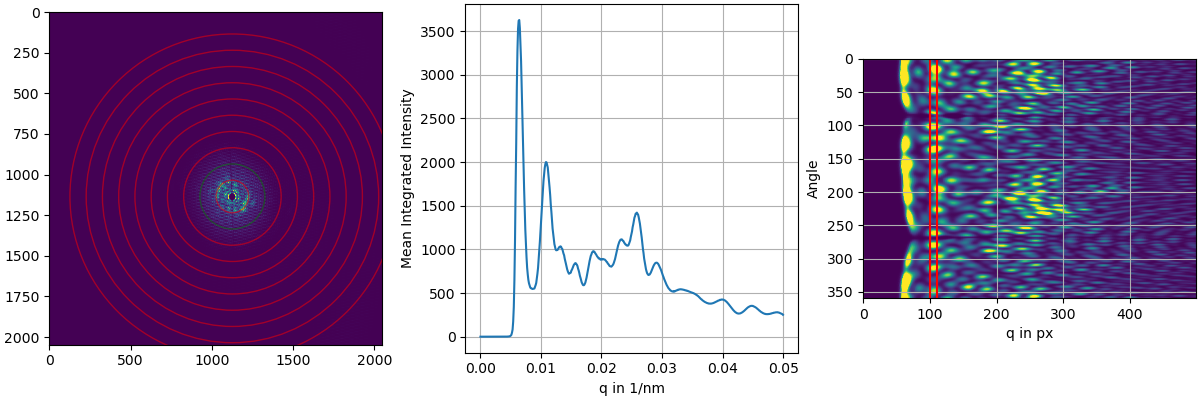

In [78]:
# The widget
aic = interactive.AzimuthalIntegrationCenter(
    #np.log10(image-np.min(image)+1),
    image,
    ai,
    c0=center[0],
    c1=center[1],
    im_data_range=[1, 98],
    radial_range=(0, 0.05),
    qlines=[100, 110],
)

In [79]:
# Get center positions from widget
center = [aic.c0, aic.c1]
print(f"Center:", center)

Center: [1135.0, 1126.0]


## Centering of image hologram

In [80]:
# Apply to topo and image
shift_c = np.array(image.shape) / 2 - center
im_c = cci.shift_image(image, shift_c)
topo_c = cci.shift_image(topo, shift_c)  # centered image

# Image Registration

Relative drift between data holograms and their corresponding topo holograms is calculated by image registration algorithm. Necessary to get well defined difference hologram. The reference is always the static background image (topo).

## Set Alignment ROI 

Set a region of interest (ROI) of reference (topo) use for image registration is performed. Can include beamstop when beamstop mask was defined.

How to use:
1. Zoom into the image and adjust your FOV until you are satisfied.
2. Save the axes coordinates.

interactive(children=(FloatRangeSlider(value=(-0.34333333333333377, 2223.0243533335392), description='contrast…

Text(0.5, 1.0, "Don't include the beamstop as this will misdirect the algorithm")

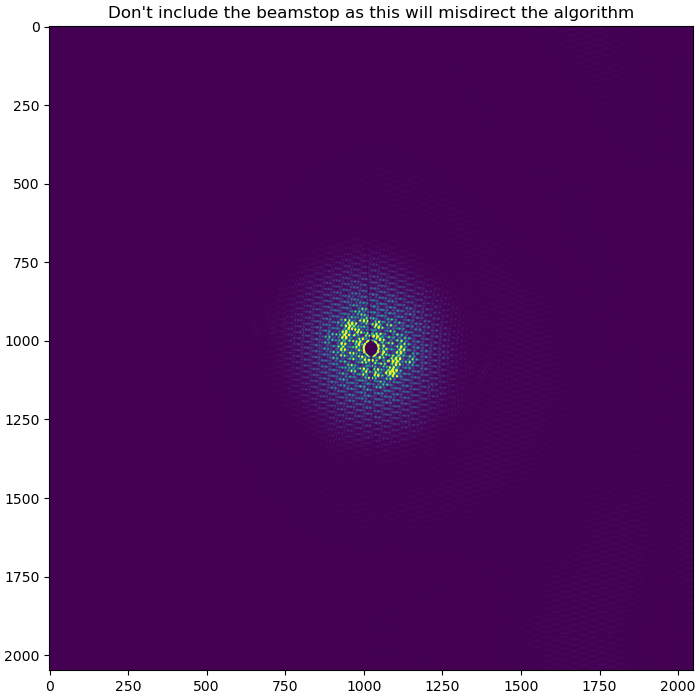

In [81]:
fig, ax = cimshow(im_c)
ax.set_title("Don't include the beamstop as this will misdirect the algorithm")

In [82]:
# Takes start and end of x and y axis
x1, x2 = ax.get_xlim()
y2, y1 = ax.get_ylim()
roi_im_reg = np.array([y1, y2, x1, x2]).astype(int)
roi_im_reg_s = np.s_[roi_im_reg[0] : roi_im_reg[1], roi_im_reg[2] : roi_im_reg[3]]

print(f"Image registration roi:", roi_im_reg)

Image registration roi: [   0 2047    0 2047]


## Calculate drift of images

In [83]:
shift = cci.image_registration(
    im_c[roi_im_reg_s],
    topo_c[roi_im_reg_s],
    method="dipy",
)
print("Relative shift is: %s"%shift)

Optimizing level 2 [max iter: 10000]
Optimizing level 1 [max iter: 1000]
Optimizing level 0 [max iter: 100]
Relative shift is: [0. 0.]


Text(0.5, 1.0, 'Auto shift: [-0. -0.]')

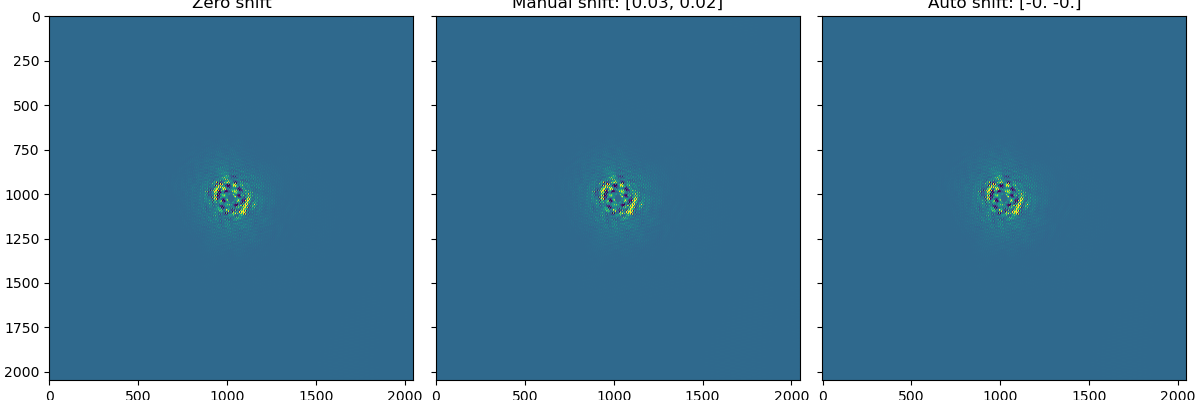

In [84]:
# Define shift manually for comparison
tmp_shift = [0.03, 0.02]

# Loop over shifts
temp_diff = np.zeros((3, im_c.shape[0], im_c.shape[1]))
shifts = [
    [0, 0],
    tmp_shift,
    -shift,
]
for i, tshift in enumerate(shifts):
    temp = cci.shift_image(im_c, tshift)
    temp_factor = cci.dyn_factor(temp, topo_c)
    temp_diff[i] = temp - temp_factor[0] * topo_c

# Plots for comparision
fig, ax = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(12, 4))
mi, ma = np.percentile(temp_diff[0], [.1, 99.9])
ax[0].imshow(temp_diff[0], vmin=mi, vmax=ma)
ax[0].set_title("Zero shift")
mi, ma = np.percentile(temp_diff[1], [.1, 99.9])
ax[1].imshow(temp_diff[1], vmin=mi, vmax=ma)
ax[1].set_title("Manual shift: %s" % shifts[1])
mi, ma = np.percentile(temp_diff[2], [.1, 99.9])
ax[2].imshow(temp_diff[2], vmin=mi, vmax=ma)
ax[2].set_title("Auto shift: %s" % np.round(shifts[2], 2))

## Correct drift of topo

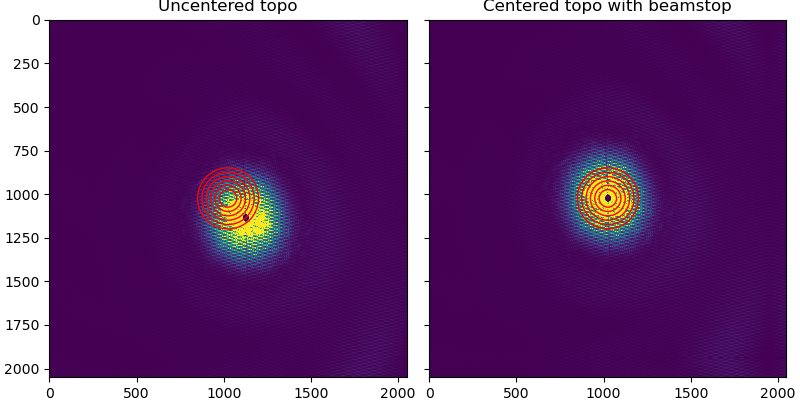

In [85]:
# Correct relative drift
topo_c = cci.shift_image(topo_c, shift)  

# Plot original and shifted holos
mi, ma = np.percentile(np.real(im_c[im_c != 0]), (0.1, 99))
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(8, 4))
ax[0].imshow(np.real(topo), cmap="viridis", vmin=mi, vmax=ma)
ax[0].set_title("Uncentered topo")
ax[1].imshow(np.real(topo_c), cmap="viridis", vmin=mi, vmax=ma)
ax[1].set_title("Centered topo with beamstop")

# Add circles with different radi r
tmp = np.array(image.shape) / 2
for r in np.arange(50, 200, 25):
    ax[0].add_artist(plt.Circle((tmp[1], tmp[0]), r, fill=None, ec="red"))
    ax[1].add_artist(plt.Circle((tmp[1], tmp[0]), r, fill=None, ec="red"))

# Calculate Projection

center= [1024. 1024.] z= 0.195
center= [1024. 1024.] z= 0.195


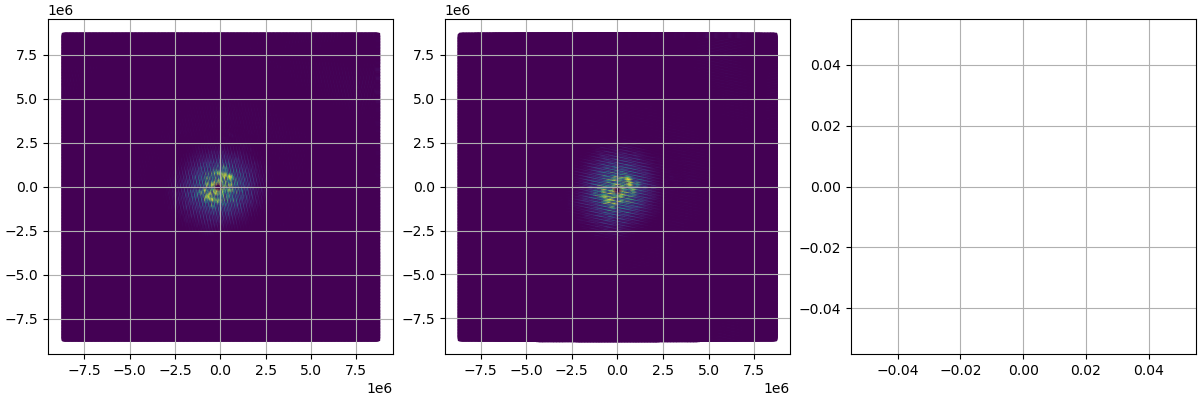

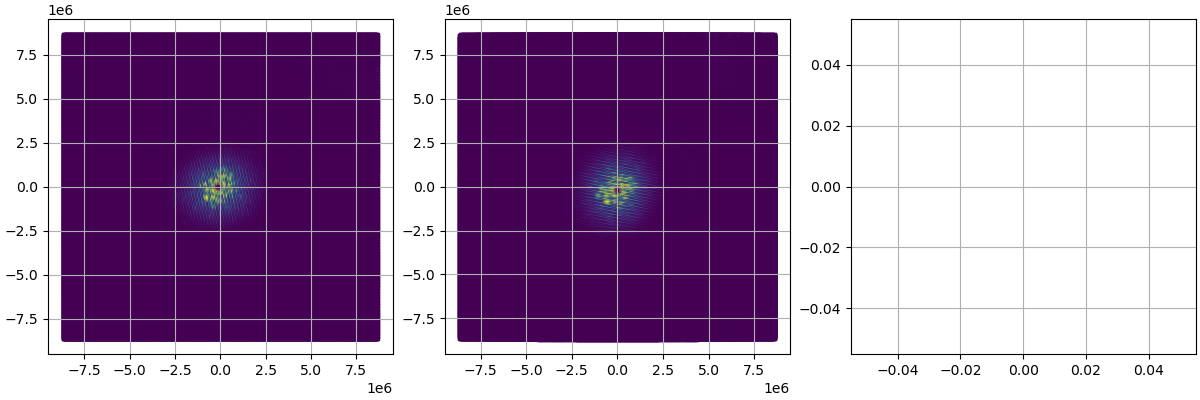

In [91]:
if project_ewalds_sphere is True:
    proj_im = PhR.inv_gnomonic2(im_c,alpha=experimental_setup["angle"], center=None, experimental_setup = experimental_setup, method='cubic' , mask=None)
    proj_topo = PhR.inv_gnomonic2(topo_c,alpha=experimental_setup["angle"], center=None, experimental_setup = experimental_setup, method='cubic' , mask=None)
    
    im_c = proj_im.copy()
    topo_c = proj_topo.copy()

# Create beamstops

We want to cover the beamstop with a smooth circle to cover its sharp edges as these would create ringing-like artifacts in the reconstruction plane. Make it only as large as necessary to keep as much information as possible.

## Manual masking of beamstop wires

Just mask the beamstop wires, broken pixels, etc. 

interactive(children=(FloatRangeSlider(value=(-0.49648211291585487, 4217.223560504909), description='contrast'…

Click on the figure to create a polygon corner.
Click `Add mask` to store coordinates and apply mask.
Press the 'esc' key to reset the polygon for new drawing.

Try holding the 'shift' key to move all of the vertices.
Try holding the 'ctrl' key to move a single vertex.
Button `Delete mask` deletes the masks recursively.


Button(button_style='warning', description='Add mask', layout=Layout(height='auto', width='100px'), style=Butt…

Button(description='Delete mask', layout=Layout(height='auto', width='100px'), style=ButtonStyle())

Output()

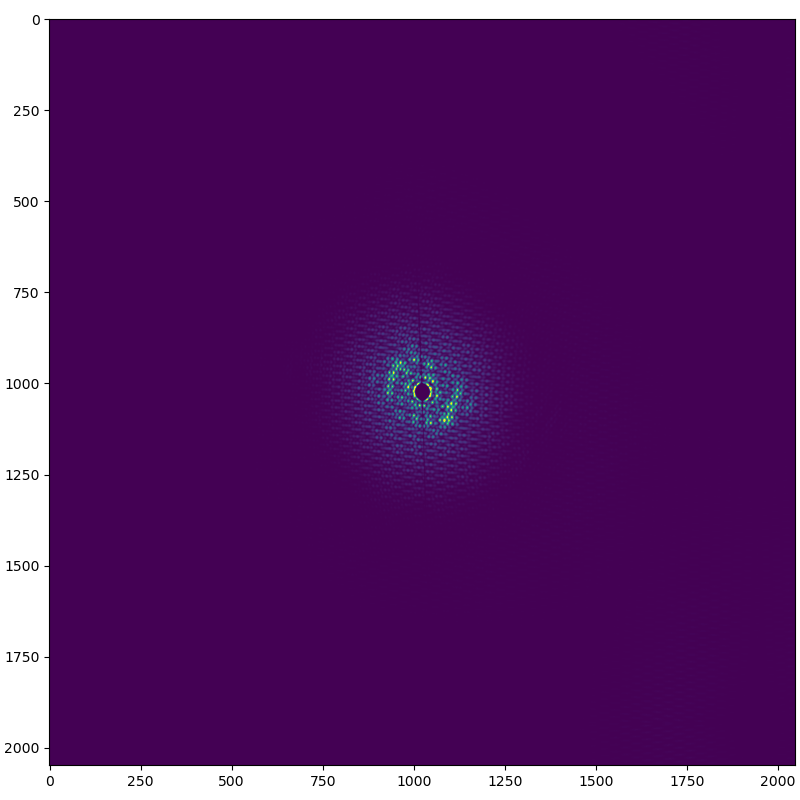

In [92]:
poly_mask = interactive.draw_polygon_mask(im_c)

Copy these coordinates into the 'load_poly_coordinates()' function:
[]


/tmp/ipykernel_45936/2759675419.py:20: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


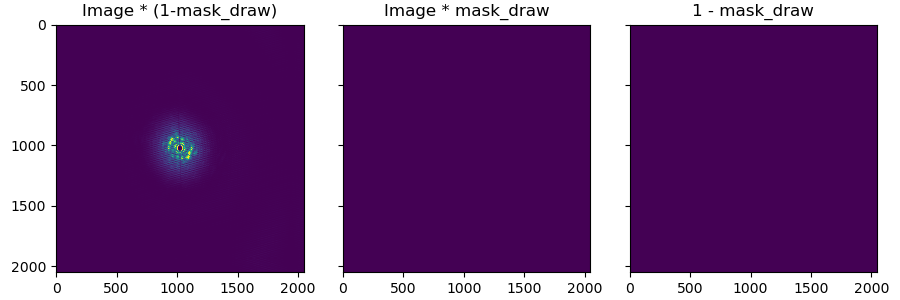

In [93]:
# Take poly coordinates and mask from widget
p_coord = poly_mask.get_vertice_coordinates()
mask_draw = poly_mask.full_mask.astype(int)

print("Copy these coordinates into the 'load_poly_coordinates()' function:")
print(p_coord)

# Plot image with beamstop and valid pixel mask
fig, ax = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(9, 3))
mi, ma = np.percentile(im_c * (1 - mask_draw), [0.1, 99.9])
ax[0].imshow(im_c * (1 - mask_draw), cmap="viridis", vmin=mi, vmax=ma)
ax[0].set_title("Image * (1-mask_draw)")

mi, ma = np.percentile(im_c * mask_draw, [0.1, 99.9])
ax[1].imshow(im_c * mask_draw, vmin=mi, vmax=ma)
ax[1].set_title("Image * mask_draw")

ax[2].imshow(1 - mask_draw)
ax[2].set_title("1 - mask_draw")
plt.tight_layout()

In [94]:
def load_poly_coordinates():
    """
    Dictionary that stores polygon corner coordinates of all drawn masks
    Example: How to add masks with name "test":
    mask_coordinates["test"] = copy coordinates from above
    """

    # Setup dictonary
    mask_coordinates = dict()

    # Mask #1
    mask_coordinates["test"] = [[(1021.6, 997.0), (1015.1, 1000.7), (1007.0, 1007.0), (1001.6, 1017.6), (1001.0, 1023.8), (1003.2, 1037.1), (1015.5, 1049.3), (1024.8, 1052.6), (1034.4, 1047.7), (1043.4, 1038.1), (1047.0, 1025.7), (1046.1, 1019.2), (1043.2, 1011.7), (1037.7, 1005.6), (1028.0, 999.0)]]
    return mask_coordinates

Text(0.5, 1.0, '1 - mask_draw')

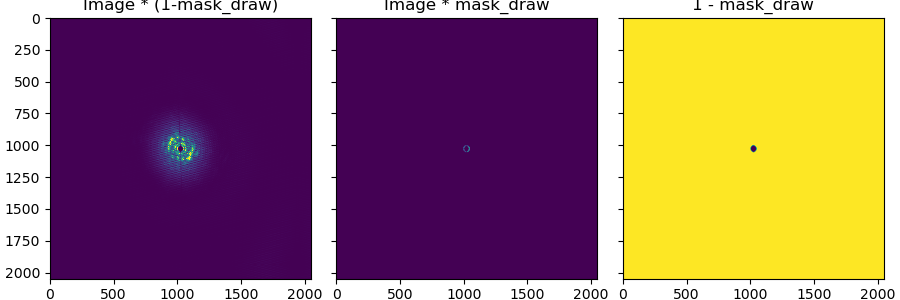

In [95]:
# Which drawn masks do you want to load? You can combine multiple masks from
# load_poly_coordinates(). Just add names of mask as strings to list like
# ["bs_small","bs_medium"]
polygon_names = ["test"]  # ["bs_test"]
mask_draw = mask_lib.load_poly_masks(
    experimental_setup["binning"] * np.array(image.shape),
    load_poly_coordinates(),
    polygon_names,
)
#mask_draw = np.zeros(im_c.shape)

# Plot image with beamstop and valid pixel mask
fig, ax = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(9, 3))
mi, ma = np.percentile(im_c * (1 - mask_draw), [0.1, 99.9])
ax[0].imshow(im_c * (1 - mask_draw), cmap="viridis", vmin=mi, vmax=ma)
ax[0].set_title("Image * (1-mask_draw)")

#mi, ma = np.percentile(im_c * mask_draw, [0.1, 90])
ax[1].imshow(im_c * mask_draw, vmin=mi, vmax=ma)
ax[1].set_title("Image * mask_draw")

ax[2].imshow(1 - mask_draw)
ax[2].set_title("1 - mask_draw")

## Finetuning of mask position

interactive(children=(FloatRangeSlider(value=(-0.2356237583864922, 2226.93016366282), description='contrast', …

interactive(children=(FloatSlider(value=0.0, description='shift_ver', layout=Layout(width='350px'), max=512.0,…

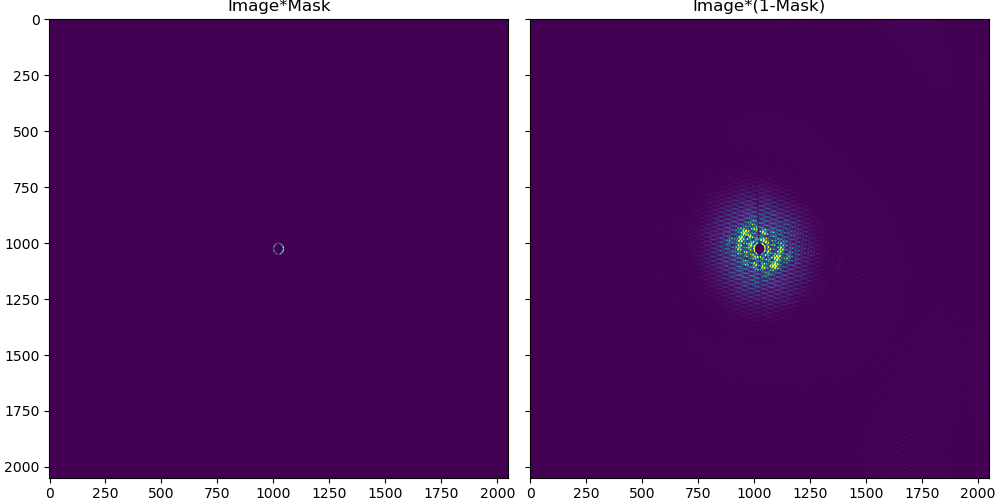

In [96]:
# Use widget to shift and expand or shrink the mask
ss_mask = interactive.Shift_Scale_Mask(im_c,mask_draw, shift = [0,0], scale = 0)

In [97]:
# Take mask, shift and scaling from widget
mask_draw, mask_shift, mask_scale = ss_mask.get_mask()

## Overview beamstops
Verify good beamstop alignment

Text(0.5, 1.0, 'Image-Topo')

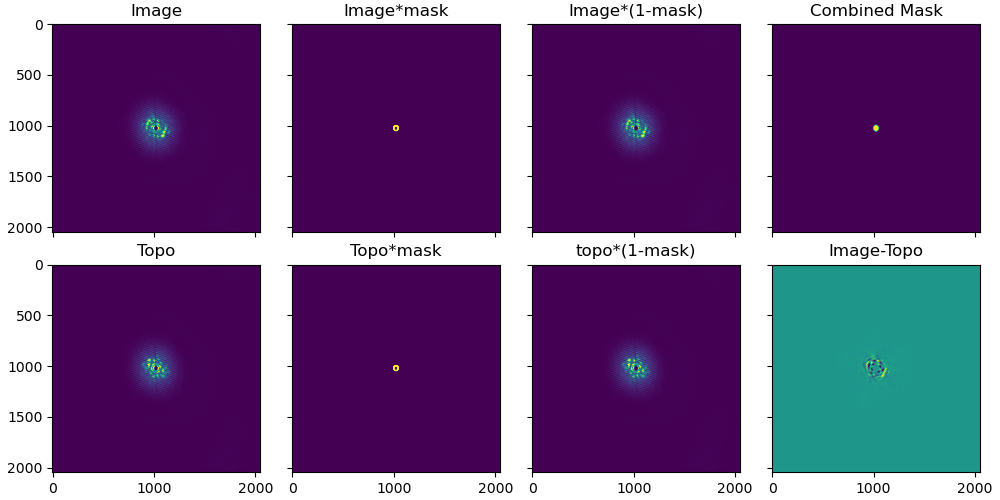

In [98]:
# Smoothing of beamstop mask
bs_smoothing = 2

# Add circular beamstop mask
mask_im = mask_draw.copy()
mask_topo = mask_draw.copy()

# Mask over-saturated pixel
mask_im = mask_im + (im_c > experimental_setup["oversaturation"])
mask_topo = mask_topo + (topo_c > experimental_setup["oversaturation"])

# Combine both
mask_pixel = mask_im + mask_topo
mask_pixel[mask_pixel > 1] = 1

# Create smooth mask for FTH reconstructions
footprint = skimage.morphology.disk(3*bs_smoothing)
mask_pixel_smooth = skimage.morphology.dilation(mask_pixel, footprint)
mask_pixel_smooth = gaussian_filter(mask_pixel_smooth, bs_smoothing)

# Plot both
fig, ax = plt.subplots(2, 4, figsize=(10, 5), sharex=True, sharey=True)
mi, ma = np.percentile(im_c, [1, 99.9])
ax[0, 0].imshow(im_c, vmin=mi, vmax=ma)
ax[0, 0].set_title("Image")
mi, ma = np.percentile(im_c * mask_im, [1, 99.99])
ax[0, 1].imshow(im_c * mask_im, vmin=mi, vmax=ma)
ax[0, 1].set_title("Image*mask")
mi, ma = np.percentile(im_c * (1 - mask_im), [0.1, 99.9])
ax[0, 2].imshow(im_c * (1 - mask_im), vmin=mi, vmax=ma)
ax[0, 2].set_title("Image*(1-mask)")
ax[0, 3].imshow(mask_pixel_smooth)
ax[0, 3].set_title("Combined Mask")

mi, ma = np.percentile(topo_c, [1, 99.9])
ax[1, 0].imshow(topo_c, vmin=mi, vmax=ma)
ax[1, 0].set_title("Topo")
mi, ma = np.percentile(topo_c * mask_im, [1, 99.99])
ax[1, 1].imshow(topo_c * mask_topo, vmin=mi, vmax=ma)
ax[1, 1].set_title("Topo*mask")
mi, ma = np.percentile(topo_c * (1 - mask_topo), [0.1, 99.9])
ax[1, 2].imshow(topo_c * (1 - mask_topo), vmin=mi, vmax=ma)
ax[1, 2].set_title("topo*(1-mask)")
mi, ma = np.percentile((im_c - topo_c) * (1 - mask_pixel_smooth), [0.1, 99.9])
ax[1, 3].imshow((im_c - topo_c) * (1 - mask_pixel_smooth), vmin=mi, vmax=ma)
ax[1, 3].set_title("Image-Topo")

# Calculate difference holograms

You can see the reconstrution of the magnetization only after subtracting the large background that you get from the diffraction on the circular object aperture (Airy Pattern). This might require a scaling factor to correct intensity changes between the hologram and the topo. Scaling factor will be determined automatically by a linear fit. If the fit seems off, there might be an issue with the data

In [99]:
# Get scaling factor and offset
factor, offset = cci.dyn_factor(
    im_c * (1 - mask_pixel),
    topo_c * (1 - mask_pixel),
    method="scalarproduct",
    verbose=True,
    plot=True,
)
factor = 1

# Calculate differences (magnetic) and sums (topographc) contrast holograms.
# _c: centered, without beamstop, _b: centered, with beamstop
diff_c = im_c / factor - topo_c - offset
sum_c = im_c / factor + topo_c - offset

Intensity correction factor: 0.6783479519554954


interactive(children=(FloatRangeSlider(value=(-1356.767185439916, 1200.5220248673656), description='contrast',…

Text(0.5, 1.0, ' Diff Id 333 - 332')

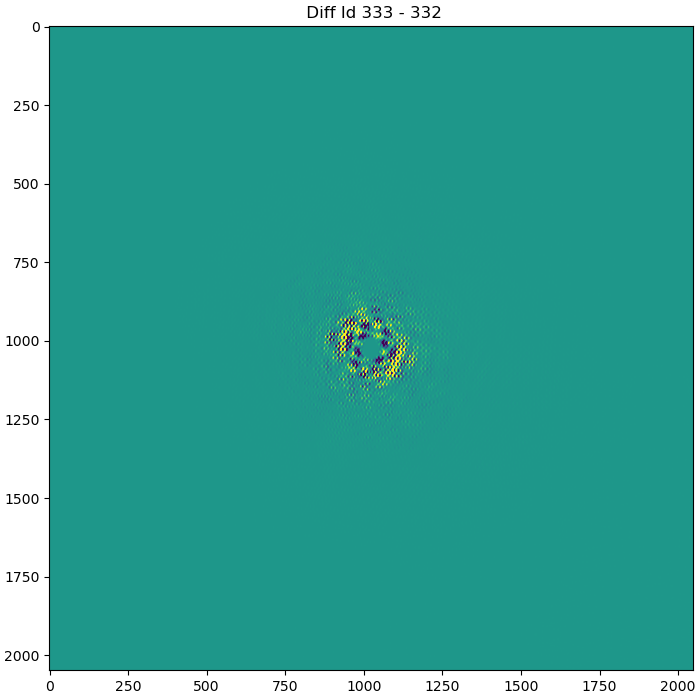

In [100]:
# Plot an example of the difference or sum hologram
fig, ax = cimshow(diff_c * (1 - mask_pixel_smooth))
ax.set_title(f" Diff Id %d - %d" % (im_id, topo_id))

# fig, ax = cimshow(sum_b)
# ax.set_title(f" Sum Id %d" % im_id)

# Reconstruct Diff Holos (FTH)

Reconstruct the hologram.

0. If you are doing heraldo, determine the rotation angle of the hologram
1. Choose a region of interest (ROI) which means selecting one reconstruction from the reconstruction plane.
2. Propagate the image and shift the phase for maximal contrast and sharpness in your ROI

In [101]:
# This is only relevant if you are doing heraldo
if heraldo is True:
    xticks, yticks = [495,522], [490,517]
    shift_rotate_widget = interactive.Shift_Rotate(im_c, shift = [0,0], angle = 0, ticks = (yticks,xticks))

## Set Patterson Map ROI

Choose the reconstructions as the ROI.

1. Zoom into the image and adjust your FOV until you are satisfied.
2. Save the axes coordinates.

interactive(children=(FloatRangeSlider(value=(-0.483338621370294, 0.6172568679402927), description='contrast',…

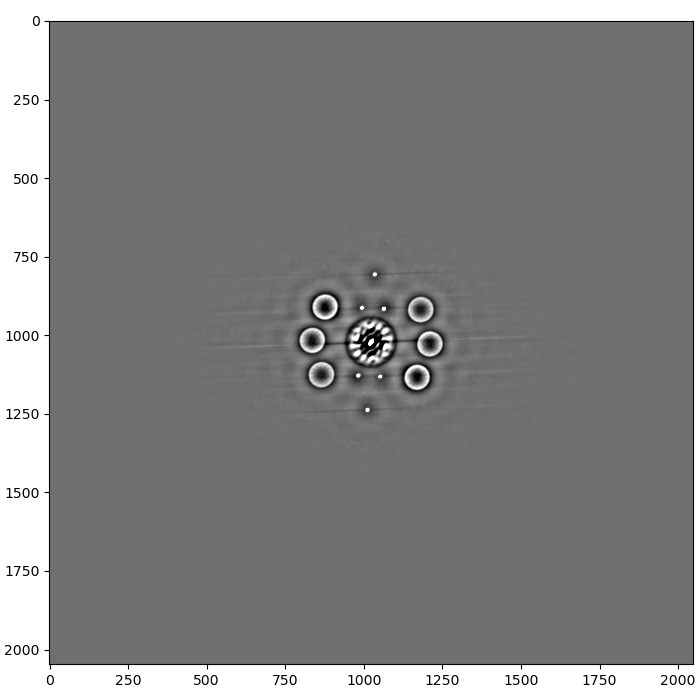

In [102]:
# Choose contrast mode
# diff_c: magnetic contrast only
# sum_c: topographic contrast only
#holo = diff_c* (1 - mask_pixel_smooth)
holo = sum_c *(1 - mask_pixel_smooth)

if heraldo is True:
    print("Doing Heraldo")
    _, _, heraldo_rotation = shift_rotate_widget.get_parameter()
    tmp, heraldo_operator  = reconstruct_heraldo(holo, experimental_setup, 
                              center = None, prop_dist = 0, phase = 0,angle = heraldo_rotation)
else:
    tmp =fth.reconstruct(holo)
    
fig, ax = cimshow(np.real(tmp), cmap="gray")

In [ ]:
# Execute to get roi
x1, x2 = ax.get_xlim()
y2, y1 = ax.get_ylim()
roi = np.array([y1, y2, x1, x2]).astype(int)  # ystart, ystop, xstart, xstop
roi_s = np.s_[roi[0] : roi[1], roi[2] : roi[3]]
print(f"Roi Reco:{roi}")

## Tune propagation and phase
Focus the image by tuning the propagation distance. This really works like focussing in a microscope.
Phase slider will move contrast between real and imaginary part. Usually we use the phase which maximizes the contrast in the real part.

In [ ]:
# Widget
if heraldo is True:
    #holo = sum_c * heraldo_operator * (1 - mask_pixel_smooth)
    holo = diff_c * heraldo_operator * (1 - mask_pixel_smooth)
elif heraldo is False:
    #holo = sum_c *(1 - mask_pixel_smooth)
    holo = diff_c *(1 - mask_pixel_smooth)

slider_prop, slider_phase, button = reco.propagate(
    holo,
    roi_s,
    phase = 0, #Initial value
    prop_dist = 0, #Initial value
    experimental_setup=experimental_setup,
    scale=(1, 99),
)

In [ ]:
# Read prop dist and phase from widget
prop_dist = slider_prop.value
phase = slider_phase.value

print(f"Propagation distance: %0.2f" % prop_dist)
print(f"Phase: %0.2f" % phase)

## Save reconstruction

Save png files of the images and a h5 file containing all important variables

In [ ]:
# Style of reconstruction plot
def plot_recon(recon, title):
    # Plot
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    fig.suptitle(title)

    vmin, vmax = np.percentile(np.real(recon), (1, 99))
    t_im1 = ax[0].imshow(np.real(recon), vmin=vmin, vmax=vmax, cmap="gray")
    ax[0].set_title("Real")
    plt.colorbar(t_im1, ax=ax[0], aspect=50)

    vmin, vmax = np.percentile(np.imag(recon), (1, 99))
    t_im2 = ax[1].imshow(np.imag(recon), vmin=vmin, vmax=vmax, cmap="gray")
    ax[1].set_title("Imag")
    plt.colorbar(t_im2, ax=ax[1], aspect=50)

In [ ]:
def get_title(data_key,im_id,topo_id,CDI=False):
    # Rotation in title
    if data_key is not None:
        data = load_data(im_id, mnemonics["pre_scan_snapshot"])

    if CDI is False:
        mode = "FTH"
    elif CDI is True:
        mode = "CDI"
        
    if data_key == "srotz":
        title = "Image %d - %d %s: %s = %.1f (%.1f deg)" % (im_id, topo_id, mode, data_key, data["srotz"], data["srotz"]-experimental_setup["z_angle_offset"])
    elif data_key == None:
        title = "Image %d - %d %s:"%(im_id, topo_id, mode)
    else:
        title = "Image %d - %d %s: %s = %.2f "%(im_id, topo_id, mode, data_key, values)
        
    return title

In [ ]:
# Create plot
holo = diff_c *(1 - mask_pixel_smooth)

# Reconstruct
if heraldo is True:
    recon, _ = reconstruct_heraldo(holo,experimental_setup,prop_dist = prop_dist, phase = phase, angle = heraldo_rotation)
elif heraldo is False:
    recon = fth.reconstruct(
        fth.propagate(holo, prop_dist * 1e-6, experimental_setup=experimental_setup)
        * np.exp(1j * phase)
    )

# Create plot
title = get_title(None,im_id,topo_id)
plot_recon(recon[roi_s], title)

# Save images
fname = join(
    folder_general,
    "Recon_ImId_%04d_RefId_%04d_%s.png" % (im_id, topo_id, USER),
)
print("Saving: %s" % fname)
plt.savefig(fname, bbox_inches="tight", transparent=False)

# Save hdf5 file
save_fth_h5()

In [ ]:
# Closes all existing plots
plt.close("all")

# Batch processing FTH (update!)

# CDI Reconstruction

## Create set of pos and neg helicity holograms

CDI algorithm needs holograms recorded wih both helicity ($\sigma = \pm 1$) as input. We use will calculate those from our previously centered and intensity normalized holograms according to;´; 

$Image(\sigma) = Topo + \sigma \cdot diff $,

In [ ]:
# Copy values from FTH reco (here topo = sum_c)
pos = (sum_c + diff_c) / 2
neg = (sum_c - diff_c) / 2

## Create Support mask
The support mask is the real-space constraint used for the (holographically-aided) phase retrieval, i.e., certain details about our sample like the sample geometry. For our samples we can directly derive a very strong constraint: The FTH reconstructions show us previsely the actual real-space sample structure, i.e., the arrangement of our aperture where x-rays are transmitted ("1") while the masked areas show no transmission ("0"). We will therefore create a binary mask that reflects this transmission as an input for the phase retrieval.

How to draw a support mask: Create a binary mask of the locations of sample apertures in the fth reconstruction. Areas with apertures are "1". Select only a single set of reconstructions (object & reference apertures) that originate from a single reference. Use the widget!

### Option 1: Execute if you want to create a new support mask with elliptical mask widget

If you really want to create a new support mask, execute next cell and then the "InteractiveCircleCoordinates"-widget

In [ ]:
# How many references do you have?
nr_ref = 3

# Setup coordinates (nr_ref + 1 coordinates, as there is always the object aperture)
support_coordinates = [
    [pos.shape[-2] // 2, pos.shape[-1] // 2, 7] for k in range(nr_ref + 1)
]

# Widget to find the positions and sizes of the different apertures
print("Cover the object & reference apertures for each set of reconstructions that originates from the same reference with circles.")
print("Optimization: Change one circle parameter, calc phase retrieval image, compare with images reconstructed with old circle parameter. Repeat!")

# Create plot
#holo = diff_c * (1 - mask_pixel_smooth)
holo = pos * (1 - mask_pixel_smooth)

# Reconstruct
if heraldo is True:
    recon, _ = reconstruct_heraldo(holo,experimental_setup,prop_dist = prop_dist, phase = phase, angle = heraldo_rotation)
elif heraldo is False:
    recon = fth.reconstruct(
        fth.propagate(holo, prop_dist * 1e-6, experimental_setup=experimental_setup)
        * np.exp(1j * phase)
    )
recon = np.abs(recon)
    
ds = interactive.InteractiveCircleCoordinates(recon,
    len(support_coordinates),
    coordinates=support_coordinates,
)

In [ ]:
# Take coordinates of circles from widget
support_coordinates = ds.get_params()

# Create supportmask from coordinates
supportmask = mask_lib.create_circle_supportmask(support_coordinates, pos.shape)

# Plot supportmask as overlay
fig, ax = plt.subplots(figsize=(6, 6))
mi, ma = np.percentile(recon, (1, 99))
ax.imshow(recon, vmin=mi, vmax=ma, cmap="gray")
ax.imshow(supportmask, alpha=0.4, cmap="binary")
ax.set_title("Image with overlayed mask")

### Option 2: Execute if you want to load an existing support mask created with elliptical mask widget

In [ ]:
def get_supportmask_coordinates(sample):
    """
    Dictionary that stores coordinates of circular support mask apertures
    """

    # Setup dictonary
    support_coord = dict()

    # coordinates
    support_coord["s2408h"] = [(911.5, 878.0, 47.5), (918.0, 1064.5, 9.0), (808.5, 1035.5, 9.0), (1024.0, 1024.0, 9.0)]

    
    return support_coord[sample]

In [ ]:
# Which supportmask to load? ("s2306a-C1", "s2308a-B1", ...)
sample = "s2408h"

# Get coordinates and create supportmask
support_coordinates = get_supportmask_coordinates(sample)

In [ ]:
# Widget to find the positions and sizes of the different apertures
print("Cover the object & reference apertures for each set of reconstructions that originates from the same reference with circles.")
print("Optimization: Change one circle parameter, calc phase retrieval image, compare with images reconstructed with old circle parameter. Repeat!")

# Plotting image
holo = sum_c* (1 - mask_pixel_smooth)

# Reconstruct
if heraldo is True:
    recon, _ = reconstruct_heraldo(holo,experimental_setup,prop_dist = prop_dist, phase = phase, angle = heraldo_rotation)
elif heraldo is False:
    recon = fth.reconstruct(
        fth.propagate(holo, prop_dist * 1e-6, experimental_setup=experimental_setup)
        * np.exp(1j * phase)
    )
recon = np.abs(recon)

ds_ellipse = interactive.InteractiveCircleCoordinates(recon,
    len(support_coordinates),
    coordinates=support_coordinates,
)

In [ ]:
# Take coordinates of circles from widget
support_coordinates = ds_ellipse.get_params()

# Create supportmask from coordinates
supportmask = mask_lib.create_circle_supportmask(support_coordinates, pos.shape)

# Plotting image
holo = pos * (1 - mask_pixel_smooth)

# Reconstruct
if heraldo is True:
    # heraldo slit
    supportmask[508:516,512:582] = 1 #horz
    
    # Do reco
    recon, _ = reconstruct_heraldo(holo,experimental_setup,prop_dist = prop_dist, phase = phase, angle = heraldo_rotation)
elif heraldo is False:
    recon = fth.reconstruct(
        fth.propagate(holo, prop_dist * 1e-6, experimental_setup=experimental_setup)
        * np.exp(1j * phase)
    )
recon = np.real(recon)


# Plot supportmask as overlay
fig, ax = plt.subplots(figsize=(6, 6))
mi, ma = np.percentile(recon, (1, 99))
ax.imshow(recon, vmin=mi, vmax=ma, cmap="gray")
ax.imshow(supportmask, alpha=0.4, cmap="binary")
ax.set_title("Image with overlayed mask")

### Take Roi
Choose the reconstructions as the ROI.

1. Zoom into the image and adjust your FOV until you are satisfied.
2. Save the axes coordinates.

In [ ]:
fig, ax = cimshow(supportmask.astype(int))

In [ ]:
roi_cdi_s = interactive.axis_to_roi(ax)
#roi_cdi = [776,1048,810,1084]
roi_cdi = [858,963,822,931]
roi_cdi_s = np.s_[roi_cdi[0]:roi_cdi[1],roi_cdi[2]:roi_cdi[3]]
print(roi_cdi_s)

## Do Phase Retrieval

In [ ]:
# Executes the algorithm
offset_vmin = .5
recon = fth.reconstruct(
    fth.propagate(holo, prop_dist * 1e-6, experimental_setup=experimental_setup)
    * np.exp(1j * phase)
)
Startimage = np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(supportmask*recon)))
Startimage = None
Startgamma = None

(
    retrieved_p,
    retrieved_n,
    retrieved_p_pc,
    retrieved_n_pc,
    bsmask_p,
    bsmask_n,
    gamma_p,
    gamma_n,
) = phase_retrieval(pos, neg, mask_pixel.astype(int), supportmask, vmin = offset_vmin, Startimage=Startimage, Startgamma=Startgamma)

## Reconstruct images from phase retrieval

In [ ]:
# New beamstop for CDI recos as phase retrieval of low-q might be insufficient. If phase retrieval worked well
# Try without beamstop: `use_bs = False`
use_bs = False
bs_diam_cdi = 25  # diameter of beamstop


# Create beamstop
if use_bs is True:
    mask_bs_cdi = 1 - cci.circle_mask(
        topo.shape, np.array(topo.shape) / 2, bs_diam_cdi, sigma=4
    )
    mask_bs_cdi = 1 - mask_pixel_smooth.copy()
elif use_bs is False:
    mask_bs_cdi = np.ones(pos.shape)  # if you don't want a beamstop

# Get Recos partial coherence
# Positiv partial coherence
p_pc = cci.reconstruct(
    fth.propagate(
        retrieved_p_pc * mask_bs_cdi,
        prop_dist_cdi * 1e-6,
        experimental_setup=experimental_setup,
    )
)

# Negative partial coherence
n_pc = cci.reconstruct(
    fth.propagate(
        retrieved_n_pc * mask_bs_cdi,
        prop_dist_cdi * 1e-6,
        experimental_setup=experimental_setup,
    )
)

# Plotting
mode = "-"
print("Fine-tuning of reconstruction parameter:")
slider_prop, slider_phase, slider_dx, slider_dy = rec.focusCDI(
    retrieved_p_pc * mask_bs_cdi,
    retrieved_n_pc * mask_bs_cdi,
    roi_cdi_s,
    mask=supportmask,
    phase=phase_cdi,
    dx=dx,
    dy=dy,
    prop_dist=prop_dist_cdi,
    experimental_setup=experimental_setup,
    operation=mode,
    max_prop_dist=3,
    scale=(1, 99),
)

In [ ]:
# Get phase from slider
phase_cdi = slider_phase.value
prop_dist_cdi = slider_prop.value

# Reconstruct images with new parameter
p_pc = fth.reconstructCDI(
    fth.propagate(
        retrieved_p_pc * mask_bs_cdi,
        prop_dist_cdi * 1e-6,
        experimental_setup=experimental_setup,
    )
) * np.exp(1j * phase_cdi)

n_pc = fth.reconstructCDI(
    fth.propagate(
        retrieved_n_pc * mask_bs_cdi,
        prop_dist_cdi * 1e-6,
        experimental_setup=experimental_setup,
    )
) * np.exp(1j * phase_cdi)


print("Phase CDI: %s" % phase_cdi)
print("Prop_dist: %s" % prop_dist_cdi)

In [ ]:
# Confirm that offset subtraction in cdi function works, i.e., only small fraction of hologram is actually masked
fig, ax = plt.subplots(2, 2, figsize=(8, 8), sharex=True, sharey=True)
tmp = np.abs(retrieved_p_pc*mask_bs_cdi)
mi, ma = np.percentile(tmp, [0.1, 99.9])
ax[0, 0].imshow(tmp, vmin=mi, vmax=ma)
ax[0, 0].set_title("Pos holo")

tmp = np.abs(retrieved_n_pc)
mi, ma = np.percentile(tmp, [0.1, 99.9])
ax[0, 1].imshow(tmp, vmin=mi, vmax=ma)
ax[0, 1].set_title("Neg holo")
ax[1, 0].imshow(bsmask_p)
ax[1, 0].set_title("Pos holo mask")
ax[1, 1].imshow(bsmask_n)
ax[1, 1].set_title("Neg holo mask")

## Save reconstructions

In [ ]:
def plot_recon(recon, title):
    # Plot
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    fig.suptitle(title)

    vmin, vmax = np.percentile(np.real(recon), (.1, 99.9))
    t_im1 = ax[0].imshow(np.real(recon), vmin=vmin, vmax=vmax, cmap="gray")
    ax[0].set_title("Real")
    plt.colorbar(t_im1, ax=ax[0], aspect=50)

    vmin, vmax = np.percentile(np.imag(recon), (.1, 99.9))
    t_im2 = ax[1].imshow(np.imag(recon), vmin=vmin, vmax=vmax, cmap="gray")
    ax[1].set_title("Imag")
    plt.colorbar(t_im2, ax=ax[1], aspect=50)

In [ ]:
# Saves only real and imaginary part
#recon = p - n
recon = (p_pc - n_pc)#   / (p_pc + n_pc)

# Plot
title = get_title(None, im_id,topo_id, CDI=True)
plot_recon(recon[roi_cdi_s], title)

# Save images
fname = join(
    folder_general,
    "Recon_ImId_%04d_RefId_%s_cdi_diff_%s.png" % (im_id, topo_id, USER),
)
print("Saving: %s" % fname)
plt.savefig(fname, bbox_inches="tight", transparent=False)

# Save h5
save_cdi_h5()

# Batch processing CDI

## Define Scan Ids

In [ ]:
# Load support mask of which sample?
sample = "test"

In [ ]:
# Define the sets for reconstructions. You can make a list or use np.arange
# im_id_set should always have ids of positive helicity holograms,
# topo_id_set those of negative helicity or a hologram of a saturated state

# You can also use nested lists: 
# in case topo_id_set = [[id1,id2],id3 it will use the sum hologram 
# calculated from [id1,id2] as topo

im_id_set = [1416]
dark_id_set = [1417]
topo_id_set = [1418]

# In case of single helicity reconstructions, adapt the helicity
# for contrast inversion
helicity = 1 * np.ones(len(im_id_set), dtype=int)  # [1,-1]

print("Dynamics Set:  %s" % im_id_set)
print("Reference Set: %s" % topo_id_set)
print("Helicity: %s" % helicity)

## Execute Phase Retrieval

In [ ]:
# Ugly Automatic processing of image stacks
recons_name = []  # for gifs
for it, im_id in enumerate(tqdm(im_id_set)):
    # Load energy and add to experimental setup
    experimental_setup["energy"] = load_key(im_id,mnemonics["energy"])
    experimental_setup["lambda"] = helper.photon_energy_wavelength(
        experimental_setup["energy"], input_unit="eV"
    )
    
    # Load angles
    experimental_setup["srotx"] = load_data(im_id,mnemonics["pre_scan_snapshot"])["srotx"]
    experimental_setup["srotz"] = load_data(im_id,mnemonics["pre_scan_snapshot"])["srotz"]
    experimental_setup["angle"] = experimental_setup["srotz"] - experimental_setup["z_angle_offset"]
    
    # Load images
    image, _ = load_processing(im_id)

    # Load dark
    dark_id = dark_id_set[it]
    if dark_id is not None:
        dark, _ = load_processing(dark_id, crop=None)
        image = image - dark

    # Get topo
    topo_id = topo_id_set[it]

    # Construct topo holo from two helicity images
    if isinstance(topo_id, list):
        print("Using Topo from sum of two helicity holograms")
        pos_id = topo_id[0]
        neg_id = topo_id[1]

        try:
            topo = load_topo_holo(pos_id, neg_id) / 2
        except:
            topo = load_topo_holo(neg_id, pos_id) / 2
        topo = cci.shift_image(
            topo, -shift_c
        )  # shift out of center so you don't need to change the worker

        # Process images
        worker_dict = worker(image, topo)

    # usual case, single topo holo
    else:
        # Load data
        print(f"Loading imageId: %04d, topoId: %04d" % (im_id, topo_id))
        topo, _ = load_processing(topo_id)

        if dark_id is not None:
            topo = topo - dark

        # Process images
        worker_dict = worker(image, topo)

        # Save topo hologram
        save_topo_holo(worker_dict["sum_c"], im_id, topo_id)   

    
    # Reconstruct
    recon = worker_dict["recon"]
    
    # Plot
    title = get_title("srotz", im_id, topo_id, CDI=False)
    plot_recon(recon[roi_cdi], title)

    # Save images
    fname = join(
        folder_general,
        "Recon_ImId_%04d_RefId_%s_fth_diff_stack_%s.png" % (im_id, topo_id, USER),
    )
    print("Saving: %s" % fname)
    plt.savefig(fname, bbox_inches="tight", transparent=False)

    # Optional: Save hdf5 file of fth data
    save_fth_h5()

    ################ CDI ###############
    # Create pos and neg helicity set
    pos = (worker_dict["sum_c"] + worker_dict["diff_c"])/2
    neg = (worker_dict["sum_c"] - worker_dict["diff_c"])/2

    # Create mask pixel
    mask_pixel = worker_dict["mask_pixel"]

    # Create supportmask from coordinates
    supportmask = mask_lib.create_circle_supportmask(support_coordinates, pos.shape)

    # Do phase retrieval
    (
        retrieved_p,
        retrieved_n,
        retrieved_p_pc,
        retrieved_n_pc,
        bsmask_p,
        bsmask_n,
        gamma_p,
        gamma_n,
    ) = phase_retrieval(pos, neg, mask_pixel, supportmask, vmin = offset_vmin, Startimage=Startimage, Startgamma=Startgamma)

    # Get Recos partial coherence
    # Positiv partial coherence
    p_pc = fth.reconstructCDI(
        fth.propagate(
            retrieved_p_pc * mask_bs_cdi,
            prop_dist_cdi * 1e-6,
            experimental_setup=experimental_setup,
        )
    )
    # Negative partial coherence
    n_pc = fth.reconstructCDI(
        fth.propagate(
            retrieved_n_pc * mask_bs_cdi,
            prop_dist_cdi * 1e-6,
            experimental_setup=experimental_setup,
        )
    )

    ##### Calc reco and optimze contrast
    recon = helicity[it] * (p_pc - n_pc)
    #_, phase_cdi = optimize_phase_contrast(recon, supportmask, method="contrast")
    phase_cdi = 0
    recon = recon * np.exp(1j * phase_cdi)
    print("Phase is:", np.round(phase_cdi, 2))
    ########

    # Plot
    title = get_title("srotz",im_id,topo_id,CDI=True)
    plot_recon(recon[roi_cdi], title)

    # Save images
    fname = join(
        folder_general,
        "Recon_ImId_%04d_RefId_%s_cdi_stack_%s.png" % (im_id, topo_id, USER),
    )

    print("Saving: %s" % fname)
    plt.savefig(fname, bbox_inches="tight", transparent=False)
    recons_name.append(fname)

    # Save files as h5
    save_cdi_h5()

    print(" ")
print("CDI stack processing finished")